In [55]:
cd ..

/Users/vijay/vijaygkd/gan


In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.utils.vis_utils import plot_model


2022-09-18 14:05:24.867588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from src.keras.model import GAN, GAN_CNN

In [3]:
%load_ext autoreload
%autoreload 2

In [42]:
import wandb
from wandb.keras import WandbCallback

## Training Utils

In [56]:
# create and save a plot of generated images (reversed grayscale)
def generate_fake_images_plot(examples, epoch=0, n=10, save=False):
    path = ''
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    
    if save:
        # save plot to file
        path = 'data/generated_plot_e%03d.png' % (epoch+1)
        plt.savefig(path)
        plt.close()
    return path

In [7]:
def plot_mnist_data(images):
    for i in range(len(images)):  
        plt.subplot(330 + 1 + i)
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.show()

## Prep Data

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)

print(f"MNIST Train Set: {x_train.shape}")
print(f"MNIST Test Set: {x_test.shape}")

MNIST Train Set: (60000, 28, 28)
MNIST Test Set: (10000, 28, 28)


In [9]:
# combine train / test data
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

input_shape = (-1, 28, 28, 1)
all_digits = all_digits.astype("float32") / 255.0  
all_digits = np.reshape(all_digits, input_shape)

In [10]:
# tensorflow dataset
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

2022-09-18 14:08:21.530972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

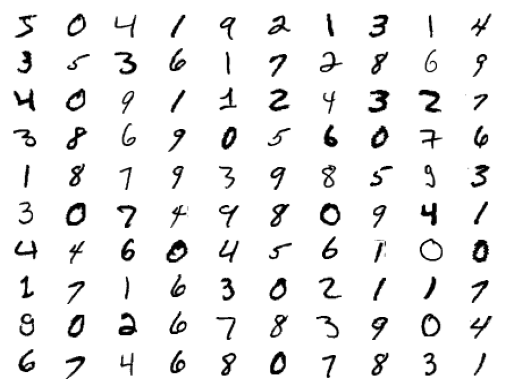

In [71]:
generate_fake_images_plot(all_digits[0:100], epoch=100, save=False)

## Model

In [17]:
gan_model = GAN_CNN()

Hello 3
Hello cnn


In [18]:
gan_model.compile(
    d_optimizer=Adam(learning_rate=3e-4),
    g_optimizer=Adam(learning_rate=3e-4),
    loss_fn=BinaryCrossentropy(),
)

In [19]:
gan_model.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [25]:
noise = gan_model.sample_random_noise(100)

In [324]:
image_noise.shape

(9, 128)

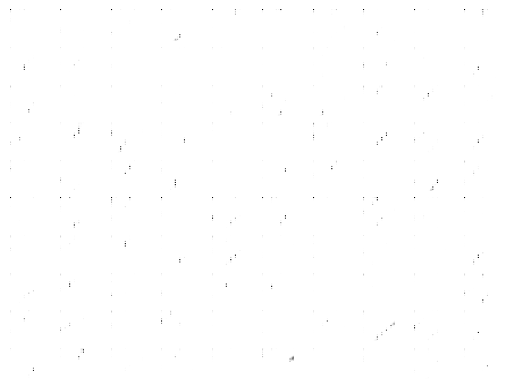

In [72]:
gan_g_output = gan_model.generator(noise)
gan_g_output = gan_g_output.numpy()#.reshape(9, 28, 28)
save_plot(gan_g_output)

In [30]:
gan_g_output.shape

(100, 28, 28, 1)

## Train GAN

In [68]:
class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=100):
        self.n=100
        
    def on_epoch_end(self, epoch, logs=None):
        noise = self.model.sample_random_noise(self.n)
        gan_g_output = self.model.generator(noise)
        gan_g_output = gan_g_output.numpy()
        path = generate_fake_images_plot(gan_g_output, epoch=epoch, n=self.n//10, save=True)
        # upload to wandb
        image = wandb.Image(path, caption=f"Generate Image epoch: {epoch+1}")
        wandb.log({"generated images": image})

In [61]:
gan_model = GAN_CNN()
gan_model.compile(
    d_optimizer=Adam(learning_rate=3e-4),
    g_optimizer=Adam(learning_rate=3e-4),
    loss_fn=BinaryCrossentropy(),
)

Hello 3
Hello cnn


In [69]:
wandb.init(project="gan-project")
wandb.config = {
  "learning_rate": 3e-4,
  "epochs": 10,
  "batch_size": batch_size
}

# Train model
gan_model.fit(dataset, 
              epochs=wandb.config['epochs'],
              callbacks=[WandbCallback(), GenerateImageCallback()]
             )

wandb.finish()

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/10
10/10 [==============================] - 8s 834ms/step - d_loss: 0.4496 - g_loss: 0.9025
Epoch 2/10
10/10 [==============================] - 8s 770ms/step - d_loss: 0.4734 - g_loss: 0.7211
Epoch 3/10
10/10 [==============================] - 8s 834ms/step - d_loss: 0.4940 - g_loss: 0.8013
Epoch 4/10
10/10 [==============================] - 8s 867ms/step - d_loss: 0.5099 - g_loss: 0.9192
Epoch 5/10
10/10 [==============================] - 8s 824ms/step - d_loss: 0.3419 - g_loss: 1.2597
Epoch 6/10
10/10 [==============================] - 8s 855ms/step - d_loss: 0.3562 - g_loss: 0.9787
Epoch 7/10
10/10 [==============================] - 9s 908ms/step - d_loss: 0.4247 - g_loss: 0.8318
Epoch 8/10
10/10 [==============================] - 8s 837ms/step - d_loss: 0.3825 - g_loss: 0.9485
Epoch 9/10
10/10 [==============================] - 8s 809ms/step - d_loss: 0.2944 - g_loss: 1.1192
Epoch 10/10
10/10 [==============================] - 9s 919ms/step - d_loss: 0.2435 - g_loss: 1.1855

### Test model

In [382]:
noise = gan_model.sample_random_noise(9)

In [383]:
#image_noise = noise.numpy().reshape(9, 28, 28)
# plot_mnist_data(image_noise)

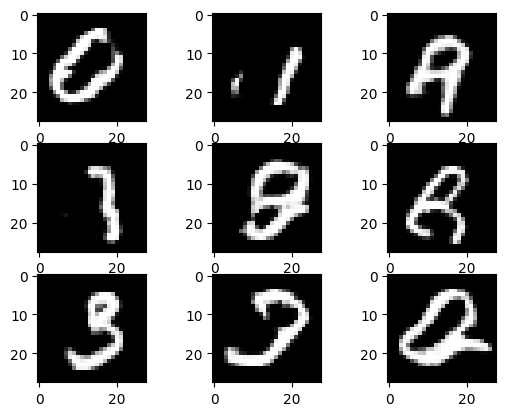

In [384]:
gan_g_output = gan_model.generator(noise)
gan_g_reshaped = gan_g_output.numpy()#.reshape(9, 28, 28)
plot_mnist_data(gan_g_reshaped)

In [385]:
gan_model.discriminator(gan_g_reshaped)

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[0.60915357],
       [0.43351775],
       [0.43775463],
       [0.265298  ],
       [0.26028347],
       [0.5656398 ],
       [0.37103817],
       [0.64274824],
       [0.38933513]], dtype=float32)>

In [386]:
gan_model.discriminator(all_digits[0:9])

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[0.67144245],
       [0.5077027 ],
       [0.6165581 ],
       [0.9206183 ],
       [0.31056586],
       [0.8072517 ],
       [0.7723774 ],
       [0.41536987],
       [0.68740493]], dtype=float32)>